<a href="https://colab.research.google.com/github/fkhandley/msds6925/blob/main/MSDS6825_practicum_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Connect to Google drive and import data files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!ls "/content/drive/My Drive"

In [ ]:
users_load = pd.read_csv('/content/drive/MyDrive/users.csv', dtype={'user_id': str})

<ipython-input-4-4c496910ee5b>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  users_load = pd.read_csv('/content/drive/MyDrive/users.csv', dtype={'user_id': str})


In [ ]:
items_load = pd.read_csv('/content/drive/MyDrive/items.csv', dtype={'order_id': str, 'user_id': str})

In [ ]:
orders_load = pd.read_csv('/content/drive/MyDrive/orders.csv', dtype={'order_id': str, 'user_id': str})

#EDA

Orders
- change delivery datetime to a datetime data type
- Check the max/min datetime are in the expected range of 2020 to present
- Identified that wait_time factors in the delay when the delivery is scheduled in the future instead of ASAP (A new feature in late 2024).  I'll need to only use wait_time before that launch if I want it to be reliable. Deliveries can be scheduled for the same day.
- Null promo_code means there was no promo_code, I'll leave null for now.
- Categorize payment methods
- Went back and updated all id's to be string datatypes in the imports. Originally imported as int64

Items
- Noted the categories looked appropriate with no unexpected results.
- Subcategory had a high rate of nulls.  I'll most likely not use it.  If I do, I'll populate the category into the blanks.
- Changed 'price' column name to be aggregate price and calculated unit price to be aggregate price divided by units
- Removed records that were not associated with an order_id in orders

Users
- Converted the sign up and birthdates to datetime objects.  Noted I lost few birthdays for being out of range.
- Removed records that were not associated with an order_id in orders

Reshape and Combine
- To move all data into one dataframe, I reduced the number of categories to 5 with one being an "other" group of the smaller categories.  I then reshaped this data so that there was an mean unit price and purchase quantity for each order for each category.  I then merged this data into orders and merged users into orders as well.  The result is an orders based dataframe with all category price point and quantity information along with the user's information.



In [ ]:
orders_load.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6612883 entries, 0 to 6612882
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   order_id           6612883 non-null  object 
 1   user_id            6612883 non-null  object 
 2   delivery_datetime  6612883 non-null  object 
 3   wait_time          6611262 non-null  float64
 4   promo_credit       6612883 non-null  float64
 5   order_price_total  6612883 non-null  float64
 6   promo_code         2894337 non-null  object 
 7   payment_method     6612883 non-null  object 
dtypes: float64(3), object(5)
memory usage: 403.6+ MB


In [ ]:
orders_load['delivery_datetime'] = pd.to_datetime(orders_load['delivery_datetime'])

In [ ]:
as_of_date = orders_load.delivery_datetime.max()

In [ ]:
print(f'Min delivery date: {orders_load.delivery_datetime.min()}')
print(f'Max delivery date: {orders_load.delivery_datetime.max()}')

Min delivery date: 2020-01-01 00:00:00.733000
Max delivery date: 2025-01-25 18:06:40.823000


In [ ]:
print(f'Min wait time: {orders_load.wait_time.min()}')
print(f'Max wait time: {orders_load.wait_time.max()}')

Min wait time: 0.4599999999999999
Max wait time: 4374308.970000001


/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:7129: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


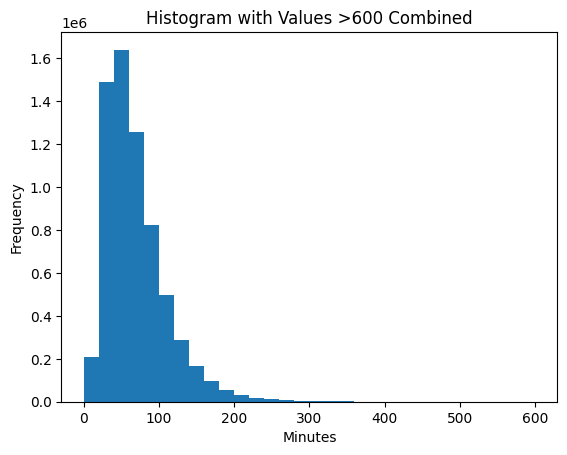

Number of values over 600: 5727


In [ ]:
bins = list(range(0, 620, 20))
bins.append(float('inf'))

plt.hist(orders_load.wait_time.clip(upper=600), bins=bins)
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.title('Histogram with Values >600 Combined')
plt.show()

over_600_count = (orders_load.wait_time > 600).sum()
print(f"Number of values over 600: {over_600_count}")

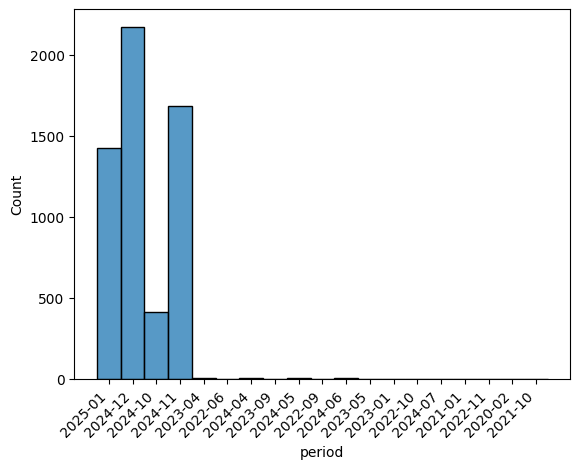

In [ ]:
long_deliveries = orders_load[orders_load.wait_time > 600].copy()
long_deliveries['period'] = long_deliveries.delivery_datetime.dt.year.astype(str) + '-' + long_deliveries.delivery_datetime.dt.month.astype(str).str.zfill(2)

sns.histplot(data=long_deliveries, x='period')
_ = plt.xticks(rotation=45, ha='right')

In [ ]:
orders_load.payment_method.unique()

array(['POB', 'ACH', 'Cash', 'Pin Debit', 'Online Debit',
       'Account Credit'], dtype=object)

In [ ]:
payment_map = {'POB':'card',
               'ACH':'ach',
               'Cash':'cash',
               'Pin Debit':'card',
               'Online Debit':'card',
               'Account Credit':'promotion'}

orders_load.payment_method = orders_load.payment_method.map(payment_map)

In [ ]:
orders_load.payment_method.unique()

array(['card', 'ach', 'cash', 'promotion'], dtype=object)

In [ ]:
items_load.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21945575 entries, 0 to 21945574
Data columns (total 9 columns):
 #   Column               Non-Null Count     Dtype  
---  ------               --------------     -----  
 0   order_id             21945575 non-null  object 
 1   user_id              21945575 non-null  object 
 2   product_name         21945575 non-null  object 
 3   catalog_id           21945575 non-null  object 
 4   product_category     21945575 non-null  object 
 5   product_subcategory  9902159 non-null   object 
 6   strain_type          21945575 non-null  object 
 7   price                21945575 non-null  float64
 8   quantity             21945575 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 1.5+ GB


In [ ]:
items_load.product_category.unique()

array(['Prerolls', 'Vaporizers', 'Flowers', 'Edibles', 'Accessories',
       'Drops', 'Concentrates', 'Topicals'], dtype=object)

In [ ]:
items_load.product_subcategory.unique()

array([nan, 'Whole Flower', 'All-In-One', 'Cartridge', 'Chocolate Bar',
       'Capsules', 'Gummies', 'Battery', 'Gio Pod', 'Hard Candy',
       'Tincture', 'Mint', 'Drink', 'Bites', 'Live Resin', 'Soft Candy',
       'Cartridge + Battery Combo', 'Shatter', 'Other', 'Balms', 'Cookie',
       'Bath Salts', 'Patch', 'Glass', 'Grinder', 'Powder', 'Topical',
       'Sprays', 'Lighter', 'Charger', 'Other Chocolates',
       'Chocolate Bon Bons', 'Oil', 'Papers', 'Brownie', 'Suga', 'Wax',
       'Dablicator', 'Crumble', 'Apparel', 'Shake', 'Hash', 'Sauce',
       'Spread', 'Rosin', 'Moon Rocks', 'Rice Crispy', 'Resin', 'Kief',
       'Infused'], dtype=object)

In [ ]:
items_load[['price','quantity']].describe()

,price,quantity
count,2.194558e+07,2.194558e+07
mean,3.193798e+01,1.181836e+00
std,2.199329e+01,6.631920e-01
min,1.000000e+00,1.000000e+00
25%,1.800000e+01,1.000000e+00
50%,2.900000e+01,1.000000e+00
75%,4.000000e+01,1.000000e+00
max,1.120000e+03,1.000000e+02


In [ ]:
items_load[items_load.price == 1120].head()

,order_id,user_id,product_name,catalog_id,product_category,product_subcategory,strain_type,price,quantity
21015427,13151547,2674666,Indica Protab - 100mg,2C36E7A6-2C73-4875-940F-B511C6CB2D9B,Edibles,Other,Indica,1120.0,14


In [ ]:
# Did a manual menu check and this items is $80 list price.  Updating price to be per unit
items_load['price_agg'] = items_load.price
items_load['unit_price'] = items_load.price / items_load.quantity
items_load.drop(columns=['price'], inplace=True)

In [ ]:
users_load.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056981 entries, 0 to 3056980
Data columns (total 5 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   user_id               3056981 non-null  object
 1   user_zipcode_current  3052136 non-null  object
 2   account_created_at    3056981 non-null  object
 3   birthdate             1865935 non-null  object
 4   gender                1346601 non-null  object
dtypes: object(5)
memory usage: 116.6+ MB


In [ ]:
users_load.account_created_at = pd.to_datetime(users_load.account_created_at)
users_load.birthdate = pd.to_datetime(users_load.birthdate, errors='coerce')

In [ ]:
users_load.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056981 entries, 0 to 3056980
Data columns (total 5 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   user_id               3056981 non-null  object        
 1   user_zipcode_current  3052136 non-null  object        
 2   account_created_at    3056981 non-null  datetime64[ns]
 3   birthdate             1865929 non-null  datetime64[ns]
 4   gender                1346601 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 116.6+ MB


In [ ]:
users_reduce = users_load[users_load['user_id'].isin(orders_load['user_id'])].copy()
del users_load
items_reduce = items_load[items_load['order_id'].isin(orders_load['order_id'])].copy()
del items_load

In [ ]:
users_reduce.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 884901 entries, 2 to 3056952
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   user_id               884901 non-null  object        
 1   user_zipcode_current  884901 non-null  object        
 2   account_created_at    884901 non-null  datetime64[ns]
 3   birthdate             877098 non-null  datetime64[ns]
 4   gender                621983 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 40.5+ MB


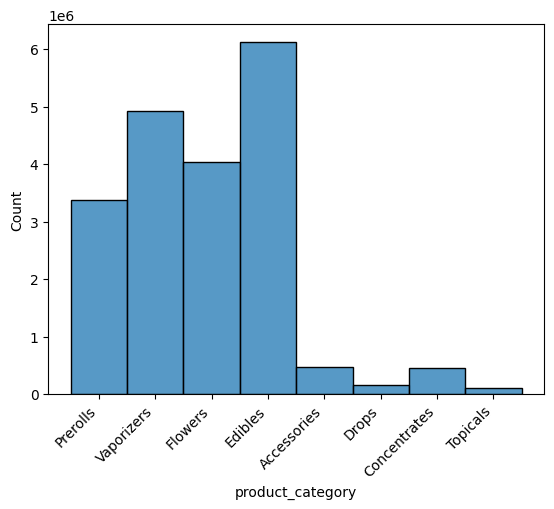

In [ ]:
sns.histplot(data=items_reduce, x='product_category')
_ = plt.xticks(rotation=45, ha='right')

In [ ]:
category_map = {'Accessories':'other',
                'Drops':'other',
                'Concentrates':'other',
                'Topicals':'other',
                'Prerolls':'prerolls',
                'Vaporizers':'vaporizers',
                'Flowers':'flower',
                'Edibles':'edibles'}

items_reduce.product_category = items_reduce.product_category.map(category_map)

In [ ]:
items_groupby = items_reduce.groupby(['order_id','product_category']).agg({'unit_price':'mean','quantity':'sum'}).reset_index()

reshaped_items = (items_groupby.pivot(index='order_id',columns='product_category',values=['unit_price', 'quantity']).reset_index())

In [ ]:
reshaped_items.head()

order_id unit_price                                   \
product_category              edibles flower other prerolls vaporizers   
0                 10000000       12.0    NaN   NaN      NaN        NaN   
1                 10000001        NaN    NaN   NaN     40.0       40.0   
2                 10000002       18.0    NaN   NaN     19.0       30.0   
3                 10000003       19.0   10.0   NaN      NaN        NaN   
4                 10000004        NaN   35.0   3.0      NaN        NaN   

                 quantity                                   
product_category  edibles flower other prerolls vaporizers  
0                     3.0    NaN   NaN      NaN        NaN  
1                     NaN    NaN   NaN      1.0        1.0  
2                     2.0    NaN   NaN      2.0        1.0  
3                     2.0    2.0   NaN      NaN        NaN  
4                     NaN    2.0   1.0      NaN        NaN

In [ ]:
reshaped_items.columns = [f"{val}_{cat}" if cat != "" else "order_id" for val, cat in reshaped_items.columns]

In [ ]:
reshaped_items.head()

,order_id,unit_price_edibles,unit_price_flower,unit_price_other,unit_price_prerolls,unit_price_vaporizers,quantity_edibles,quantity_flower,quantity_other,quantity_prerolls,quantity_vaporizers
0,10000000,12.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
1,10000001,NaN,NaN,NaN,40.0,40.0,NaN,NaN,NaN,1.0,1.0
2,10000002,18.0,NaN,NaN,19.0,30.0,2.0,NaN,NaN,2.0,1.0
3,10000003,19.0,10.0,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN
4,10000004,NaN,35.0,3.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN


In [ ]:
reshaped_items.fillna(0, inplace=True)

In [ ]:
orders_load = orders_load.merge(reshaped_items, on='order_id', how='left')

In [ ]:
orders_load = orders_load.merge(users_reduce, on='user_id', how='left')

In [ ]:
orders_load.head()

,order_id,user_id,delivery_datetime,wait_time,promo_credit,order_price_total,promo_code,payment_method,unit_price_edibles,unit_price_flower,...,unit_price_vaporizers,quantity_edibles,quantity_flower,quantity_other,quantity_prerolls,quantity_vaporizers,user_zipcode_current,account_created_at,birthdate,gender
0,10223781,881610,2022-02-19 22:57:24.310,71.69,23.8,107.00,sweet 021922,card,22.666667,0.0,...,20.000000,3.0,0.0,1.0,0.0,1.0,94122.0,2019-01-19 20:31:19.953,1992-07-30,NaN
1,13383034,853330,2024-06-29 21:19:35.750,90.67,30.0,91.95,brunch 06262024,ach,0.000000,0.0,...,30.000000,0.0,0.0,2.0,0.0,2.0,94087.0,2018-12-27 16:10:43.067,1996-05-11,male
2,10994529,881610,2022-08-14 19:14:51.323,49.04,19.6,201.59,self8142022,ach,18.000000,0.0,...,25.000000,6.0,0.0,1.0,0.0,2.0,94122.0,2019-01-19 20:31:19.953,1992-07-30,NaN
3,11316864,881610,2022-11-04 01:54:20.070,43.59,24.9,157.63,thurs 11032022,ach,11.800000,0.0,...,27.500000,11.0,0.0,0.0,0.0,2.0,94122.0,2019-01-19 20:31:19.953,1992-07-30,NaN
4,11717940,881610,2023-02-12 19:14:35.943,89.89,21.0,237.32,super 02122023,ach,17.200000,0.0,...,28.666667,11.0,0.0,0.0,0.0,3.0,94122.0,2019-01-19 20:31:19.953,1992-07-30,NaN


In [ ]:
orders_load.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6612883 entries, 0 to 6612882
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   order_id               6612883 non-null  object        
 1   user_id                6612883 non-null  object        
 2   delivery_datetime      6612883 non-null  datetime64[ns]
 3   wait_time              6611262 non-null  float64       
 4   promo_credit           6612883 non-null  float64       
 5   order_price_total      6612883 non-null  float64       
 6   promo_code             2894337 non-null  object        
 7   payment_method         6612883 non-null  object        
 8   unit_price_edibles     6612722 non-null  float64       
 9   unit_price_flower      6612722 non-null  float64       
 10  unit_price_other       6612722 non-null  float64       
 11  unit_price_prerolls    6612722 non-null  float64       
 12  unit_price_vaporizers  66127

- strange that there are null values in the price and quantities, meaning there were about 100 records in orders with no record of items.  This is probably related to orders in process without items as I queiried the data during operating hours.

In [ ]:
del reshaped_items
del users_reduce
del items_reduce

In [ ]:
orders_load['age_at_purchase'] = round(orders_load.delivery_datetime.dt.year - orders_load.birthdate.dt.year)

orders_load['account_age_at_purchase'] =  (orders_load.delivery_datetime.dt.year - orders_load.account_created_at.dt.year)*12+orders_load.delivery_datetime.dt.month - orders_load.account_created_at.dt.month


In [ ]:
orders_load.head()

,order_id,user_id,delivery_datetime,wait_time,promo_credit,order_price_total,promo_code,payment_method,unit_price_edibles,unit_price_flower,...,quantity_flower,quantity_other,quantity_prerolls,quantity_vaporizers,user_zipcode_current,account_created_at,birthdate,gender,age_at_purchase,account_age_at_purchase
0,10223781,881610,2022-02-19 22:57:24.310,71.69,23.8,107.00,sweet 021922,card,22.666667,0.0,...,0.0,1.0,0.0,1.0,94122.0,2019-01-19 20:31:19.953,1992-07-30,NaN,30.0,37
1,13383034,853330,2024-06-29 21:19:35.750,90.67,30.0,91.95,brunch 06262024,ach,0.000000,0.0,...,0.0,2.0,0.0,2.0,94087.0,2018-12-27 16:10:43.067,1996-05-11,male,28.0,66
2,10994529,881610,2022-08-14 19:14:51.323,49.04,19.6,201.59,self8142022,ach,18.000000,0.0,...,0.0,1.0,0.0,2.0,94122.0,2019-01-19 20:31:19.953,1992-07-30,NaN,30.0,43
3,11316864,881610,2022-11-04 01:54:20.070,43.59,24.9,157.63,thurs 11032022,ach,11.800000,0.0,...,0.0,0.0,0.0,2.0,94122.0,2019-01-19 20:31:19.953,1992-07-30,NaN,30.0,46
4,11717940,881610,2023-02-12 19:14:35.943,89.89,21.0,237.32,super 02122023,ach,17.200000,0.0,...,0.0,0.0,0.0,3.0,94122.0,2019-01-19 20:31:19.953,1992-07-30,NaN,31.0,49


In [ ]:
orders_load['promo_perc'] = orders_load['promo_credit'] / orders_load['order_price_total']
orders_load['month'] = orders_load['delivery_datetime'].dt.month

In [ ]:
orders_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6612883 entries, 0 to 6612882
Data columns (total 26 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   order_id                 object        
 1   user_id                  object        
 2   delivery_datetime        datetime64[ns]
 3   wait_time                float64       
 4   promo_credit             float64       
 5   order_price_total        float64       
 6   promo_code               object        
 7   payment_method           object        
 8   unit_price_edibles       float64       
 9   unit_price_flower        float64       
 10  unit_price_other         float64       
 11  unit_price_prerolls      float64       
 12  unit_price_vaporizers    float64       
 13  quantity_edibles         float64       
 14  quantity_flower          float64       
 15  quantity_other           float64       
 16  quantity_prerolls        float64       
 17  quantity_vaporizers      fl

#My Code

end_date = pd.Timestamp('today').replace(year=pd.Timestamp('today').year - 1, month=12, day=31, hour=11, minute=59)

results = []

for user_id in orders_load.user_id.unique():
  customer_orders = orders_load[orders_load['user_id'] == user_id]
  next_year = customer_orders.delivery_datetime.min().year +1
  start_date = pd.Timestamp(year=next_year, month=1, day=1, hour=1, minute=1)
  filtered_orders = customer_orders[(customer_orders['delivery_datetime'] >= start_date) & (customer_orders['delivery_datetime'] <= end_date)]

  if filtered_orders.empty:
    continue

  months = pd.Series(0, index=range(1,13))
  monthly_counts = filtered_orders['month'].value_counts()
  months.update(monthly_counts)
  counts_array = months.values
  exp_counts = np.exp(counts_array - np.max(counts_array))
  softmax_scores = exp_counts / exp_counts.sum()

  results_dict = {'user_id':user_id, **{f'month_{i+1}_score': score for i, score in enumerate(softmax_scores)}}
  results.append(results_dict)

user_seasonality = pd.DataFrame(results)

In [ ]:
#Claude's Code

def calculate_monthly_scores(orders_load):
   # Calculate end_date once
   end_date = pd.Timestamp('today').replace(year=pd.Timestamp('today').year - 1, month=12, day=31, hour=11, minute=59)

   # Pre-calculate next years and filter
   next_years = orders_load.groupby('user_id')['delivery_datetime'].min().map(lambda x: pd.Timestamp(year=x.year + 1, month=1, day=1))
   mask = (orders_load['delivery_datetime'].map(lambda x: (x >= next_years[orders_load['user_id']])) & (orders_load['delivery_datetime'] <= end_date))
   filtered_orders = orders_load[mask]
   del orders_load, mask, next_years

   # Get monthly counts
   monthly_counts = pd.crosstab(filtered_orders['user_id'], filtered_orders['month'], dropna=False).reindex(columns=range(1,13), fill_value=0)
   del filtered_orders

   # Calculate softmax
   exp_counts = np.exp(monthly_counts.values - np.max(monthly_counts.values, axis=1, keepdims=True))
   softmax_scores = exp_counts / np.sum(exp_counts, axis=1, keepdims=True)
   del exp_counts

   # Create result
   result_df = pd.DataFrame(softmax_scores, index=monthly_counts.index, columns=[f'month_{i+1}_score' for i in range(12)])
   del softmax_scores, monthly_counts

   result_df.index.name = 'user_id'
   return result_df.reset_index()

In [ ]:
%%time
user_seasonality = calculate_monthly_scores(orders_load)

In [ ]:
user_seasonality.head()

In [ ]:
user_seasonality.to_csv('/content/drive/My Drive/user_seasonality.csv', index=False)

In [ ]:
orders_load.to_csv('/content/drive/My Drive/orders_cleaned.csv', index=False)